# KNN and SVN over Fashion MNIST Dataset

# a) Load Data and display 10 representative images from each class

In [119]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt 
from sklearn import metrics
import pickle

# Classification Methods
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,accuracy_score

import pandas as pd

import time

In [155]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels),(test_images, test_labels) = fashion_mnist.load_data()



<Figure size 1440x1440 with 0 Axes>

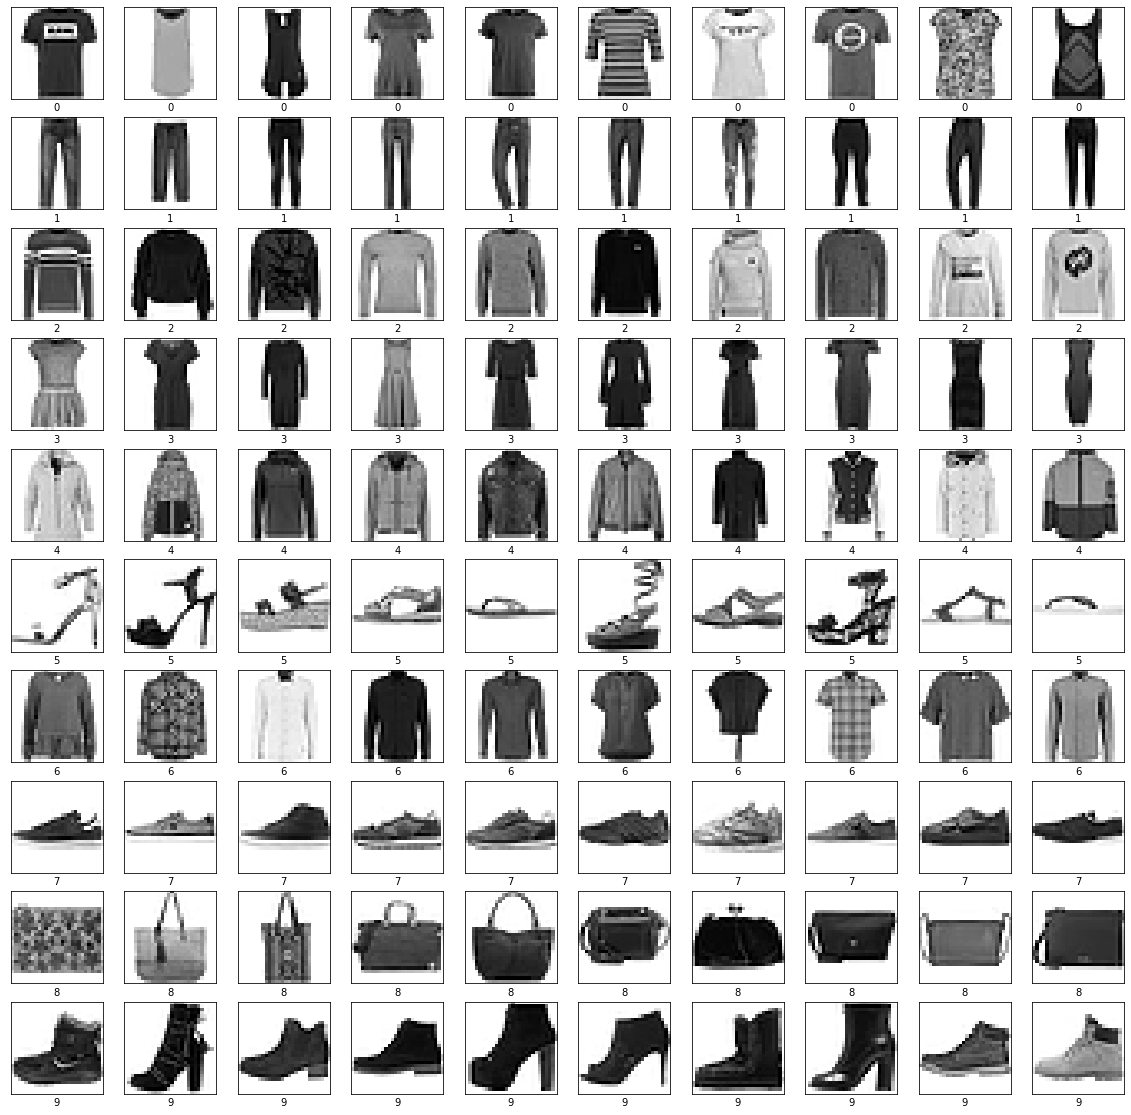

In [165]:
plt.figure(figsize=(20,20))

# Get unique labels

unique_labels = np.unique(train_labels)

# Loop over the unique labels to display images

plt.figure(figsize = (20,20))

for label in unique_labels:
    
    count = 0
    
    for i in range(6000):
        
        if train_labels[i] == label:
            
            factor = 10 * label
            plt.subplot(10, 10, count + factor + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(train_images[i], cmap = plt.cm.binary)
            plt.xlabel(train_labels[i])
            
            count += 1
            if count == 10:
                break

plt.show()

# b) Implement KNN, Logistic Regression, SVM (with linear and rbf kernel)

## Setup for recording training and testing time

In [43]:
time_table = {}

## 1. Using SVM 

Sklearn identifies when a binary classifier is being used for a multi-class classification. It automatically chooses to run the algorithm in a *One-versus-One* strategy for SVM. SVM does not scale well with the size of dataset. Therefore, running the classifier in a *One-versus-the-rest* strategy would lead to poor performance for SVM.


### rbf kernel

#### Under the Hood
The SVC model uses rbf kernel by default. <br>
It does a One-verus-One strategy thus training (N * (N - 1)/2) = 45 classifiers to predict the labels of each class. it creates one classifier for each pair of classes, compares the similarity scores and chooses the highest one as the new label.

C = 0.3 and without scaling took lesser time to run but gave an accuracy of 0.8647 <br>
<ol> <b>C </b> = $10^2$ </ol>
<ol> <b>max_iter </b> = 10000 </ol>

In [76]:
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images.reshape(60000,784))
test_images_scaled = scaler.transform(test_images.reshape(10000,784))

In [78]:
tic_train_svm = time.time()
svm_clf = SVC(C=10**2, max_iter = 10000)
svm_clf = svm_clf.fit(train_images_scaled,train_labels)
toc_train_svm = time.time()
print("Training time SVM (rbf kernel): ",toc_train_svm-tic_train_svm)

Training time SVM (rbf kernel):  519.0786609649658


C:\Users\prajw\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [79]:
filename_rbf = 'SVM_RBF.sav'
pickle.dump(svm_clf, open(filename_rbf, 'wb'))

In [82]:
loaded_svm_clf = pickle.load(open(filename_rbf, 'rb'))
tic_test_svm = time.time()
y_pred_svm = loaded_svm_clf.predict(test_images_scaled.reshape(10000,784))
toc_test_svm = time.time()
print("Testing time SVM RBF: {} s".format(toc_test_svm-tic_test_svm))

Testing time SVM RBF: 179.41834092140198 s


In [83]:
# Accuracy
acc_rbf = accuracy_score(test_labels,y_pred_svm)
print("Accuracy: ",acc_rbf)

Accuracy:  0.8935


In [84]:
# Documenting training and testing time
train_svmr = toc_train_svm-tic_train_svm
test_svmr = toc_test_svm-tic_test_svm
time_table['SVM RBF'] = [train_svmr,test_svmr,acc_rbf]

### Linear kernel

<ol>
    <li> Set max iter to speed up computations </li>
    <li> Set C = the regularization parameter <p>C=0.3 took 29 mins to train. Hence chose a much larger value for C  </p> </li>
    <li> Scaled the data to increase accuracy </li>
    </ol>

In [86]:
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images.reshape(60000,784))
test_images_scaled = scaler.transform(test_images.reshape(10000,784))

In [87]:
tic_train_svml = time.time()
svm_clf_linear = SVC(kernel='linear',cache_size=14000,max_iter=10000, C=10**2)
svm_clf_linear = svm_clf_linear.fit(train_images_scaled.reshape(60000,784),train_labels)
toc_train_svml = time.time()
print("Training time SVM Linear Kernel: ",toc_train_svml-tic_train_svml)

Training time SVM Linear Kernel:  5070.41893529892


C:\Users\prajw\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [88]:
filename_linear = 'SVM_LINEAR.sav'
pickle.dump(svm_clf_linear, open(filename_linear, 'wb'))

In [89]:
#loaded_svm_linear = pickle.load(open(filename_linear, 'rb'))
tic_test_svml = time.time()
y_pred_svml = svm_clf_linear.predict(test_images.reshape(10000,784))
toc_test_svml = time.time()
print("Testing time SVM Linear: {} s".format(toc_test_svml-tic_test_svml))

Testing time SVM Linear: 206.4313702583313 s


In [90]:
# Accuracy
acc_linear = accuracy_score(test_labels,y_pred_svml)
print("Accuracy: ",acc_linear)

Accuracy:  0.5918


In [95]:
# Documenting training and testing time
train_linear = toc_train_svml-tic_train_svml
test_linear = toc_test_svml-tic_test_svml
time_table['SVM Linear'] = [train_linear,test_linear,acc_linear]

### K-NN Classifier

<b>weights </b> : ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.      <br>
<b>Algorithm </b> : 'ball_tree'  Used the ball tree algorithm to speed up computations as it saves time approximating distance values for points near to a point that the calculation is already done for.<br>

In [32]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree')

In [34]:
tic_train_knn = time.time()
knn_model = knn.fit(train_images.reshape(60000,784),train_labels)
toc_train_knn = time.time()
print("Training time KNN: ",toc_train_knn-tic_train_knn)

Training time KNN:  21.018155336380005


In [46]:
filename_knnb = 'KNN_BALL_TREE.sav'
pickle.dump(knn_model, open(filename_knnb, 'wb'))

In [39]:
tic_test_knn = time.time()
y_pred = knn_model.predict(test_images.reshape(10000,784))
toc_test_knn = time.time()
print("Testing time KNN: {} s".format(toc_test_knn-tic_test_knn))

Testing time KNN: 629.2252297401428 s


In [70]:
acc_knn = accuracy_score(test_labels,y_pred)
print("Accuracy: ",acc)

Accuracy:  0.8647


In [93]:
# Documenting training and testing time
train_knn = toc_train_knn-tic_train_knn
test_knn = toc_test_knn-tic_test_knn
time_table['KNN'] = [train_knn,test_knn,acc_knn]

### Logistic Regression

<b>C </b> : Choosing a stronger regularization to increase accuracy   <br>
<b>penalty </b> : Choosing l1 penalty because log     <br>
<b>tol </b> : When the loss or score is not improving by at least tol for two consecutive iterations, convergence is said to be reached and training stops.   <br>

In [49]:
tic_train_log = time.time()

log_reg = LogisticRegression(C=50. / 60000, penalty='l1', solver='saga', tol=0.1)
log_reg.fit(train_images.reshape(60000,784), train_labels)

toc_train_log = time.time()
print("Training time Logistic Regression: ",toc_train_log-tic_train_log)

Training time Logistic Regression:  38.601680278778076


In [100]:
toc_test_log = time.time()
%time y_pred_log = log_reg.predict(test_images.reshape(10000,784))
toc_test_log = time.time()
print("Testing time Logistic Regression: {} s".format(toc_test_log-toc_test_log))

Wall time: 47.9 ms
Testing time Logistic Regression: 0.0 s


In [67]:
acc_log = accuracy_score(test_labels,y_pred_log)
print("Accuracy: ",acc)

Accuracy:  0.8647


In [73]:
# Documenting training and testing time
train_log = toc_train_log-tic_train_log
test_log = toc_test_log-toc_test_log
time_table['Logistic Regression'] = [train_log,test_log,acc_log]

# d) Report train and test time for all models

In [96]:
time_table

{'Logistic Regression': [38.601680278778076, 0.0, 0.8401],
 'KNN': [21.018155336380005, 11418.61334848404, 0.8577],
 'SVM RBF': [519.0786609649658, 179.41834092140198, 0.8935],
 'SVM Linear': [5070.41893529892, 206.4313702583313, 0.5918]}

In [99]:
report = pd.DataFrame.from_dict(time_table, orient='index',columns=['Training Time (s)', 'Testing Time (s)', 'Accuracy'])
report

,Training Time (s),Testing Time (s),Accuracy
Logistic Regression,38.601680,0.000000,0.8401
KNN,21.018155,11418.613348,0.8577
SVM RBF,519.078661,179.418341,0.8935
SVM Linear,5070.418935,206.431370,0.5918


<ol>
    <li>Logistic Regression and KNN have comparable training but KNN has a much larger testing time for just a little improvement of accuracy. While choosing between these two one can take a call depending upon the use case. That is, id that sight improvement in accuracy worth the large increase in testing time? </li>
    <li>SVM using RBF kernel gives the highest accuracy among the models, but it has significantly high training and testing time. Although lesser than SVM using linear kernel. </li>

</ol>